In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import tensorflow as tf

device_name = tf.test.gpu_device_name()

if device_name == '/device:GPU:0':
    print('Found GPU at: {}'.format(device_name))
else:
    raise SystemError('GPU device not found')

Found GPU at: /device:GPU:0


In [4]:
import torch

if torch.cuda.is_available():

    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


In [5]:
!pip install transformers

In [6]:
import json

# JSON 파일 읽기 및 데이터 추출
def extract_captions_labels(json_file_path, num_samples = None):
    with open(json_file_path, "r") as json_file:
        data = json.load(json_file)

    captions_labels = []
    annotations = data["annotations"]

    if num_samples is not None:
        annotations = annotations[:num_samples]

    for annotation in annotations:
        caption = annotation["caption"]
        label = annotation["danger_score"]
        captions_labels.append((caption, label))

    return captions_labels

# file1.json에서 데이터 추출
file1_captions_labels = extract_captions_labels("/content/drive/MyDrive/train_abnormal_dataset.json")

# file2.json (COCO 2017 Dataset)에서 2500개 데이터 추출
file2_captions_labels = extract_captions_labels("/content/drive/MyDrive/modified_file.json", 500)

# 두 데이터 리스트를 합치기
captions_labels = file1_captions_labels + file2_captions_labels

print(len(captions_labels))

captions_labels = list(set(captions_labels))

print(len(captions_labels))

2591
2400


In [7]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

# 데이터 분리
sentences, labels = zip(*captions_labels)

In [8]:
from transformers import BertTokenizer

print('Loading BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

Loading BERT tokenizer...


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [9]:
# 0번 문장으로 테스트
print(' Original: ', sentences[0])

print('Tokenized: ', tokenizer.tokenize(sentences[0]))

print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(sentences[0])))

 Original:  A colorful living area with living room, dining room and a kitchen.
Tokenized:  ['a', 'colorful', 'living', 'area', 'with', 'living', 'room', ',', 'dining', 'room', 'and', 'a', 'kitchen', '.']
Token IDs:  [1037, 14231, 2542, 2181, 2007, 2542, 2282, 1010, 7759, 2282, 1998, 1037, 3829, 1012]


In [10]:
max_len = 0

for sent in sentences:

    input_ids = tokenizer.encode(sent, add_special_tokens=True)

    max_len = max(max_len, len(input_ids))

print('Max sentence length: ', max_len)

Max sentence length:  35


In [11]:
input_ids = []
attention_masks = []

for sent in sentences:

    encoded_dict = tokenizer.encode_plus(
                        sent,
                        add_special_tokens = True,
                        max_length = 64,
                        pad_to_max_length = True,
                        return_attention_mask = True,
                        return_tensors = 'pt',
                   )

    input_ids.append(encoded_dict['input_ids'])
    attention_masks.append(encoded_dict['attention_mask'])


input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

print('Original: ', sentences[0])
print('Token IDs:', input_ids[0])

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2870: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Original:  A colorful living area with living room, dining room and a kitchen.
Token IDs: tensor([  101,  1037, 14231,  2542,  2181,  2007,  2542,  2282,  1010,  7759,
         2282,  1998,  1037,  3829,  1012,   102,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0])


In [12]:
from torch.utils.data import TensorDataset, random_split

dataset = TensorDataset(input_ids, attention_masks, labels)

train_size = int(0.99 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

2,376 training samples
   24 validation samples


In [13]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

batch_size = 32

train_dataloader = DataLoader(
            train_dataset,
            sampler = RandomSampler(train_dataset),
            batch_size = batch_size
        )

validation_dataloader = DataLoader(
            val_dataset,
            sampler = SequentialSampler(val_dataset),
            batch_size = batch_size
        )

In [14]:
from transformers import BertForSequenceClassification, AdamW, BertConfig

model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = 8,
    output_attentions = False,
    output_hidden_states = False,
)

model.cuda()

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [15]:
optimizer = AdamW(model.parameters(),
                  lr = 2e-5,
                  eps = 1e-8
                )


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [16]:
from transformers import get_linear_schedule_with_warmup

epochs = 4

total_steps = len(train_dataloader) * epochs

scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = 0,
                                            num_training_steps = total_steps)

In [17]:
import numpy as np

def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [18]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    elapsed_rounded = int(round((elapsed)))

    return str(datetime.timedelta(seconds=elapsed_rounded))


In [19]:
import random
import numpy as np


seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)


training_stats = []

total_t0 = time.time()


for epoch_i in range(0, epochs):

    # ========================================
    #               Training
    # ========================================


    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')


    t0 = time.time()


    total_train_loss = 0

    model.train()

    for step, batch in enumerate(train_dataloader):

        if step % 40 == 0 and not step == 0:

            elapsed = format_time(time.time() - t0)

            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))


        # `batch` contains three pytorch tensors:
        #   [0]: input ids
        #   [1]: attention masks
        #   [2]: labels
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        model.zero_grad()

        result = model(b_input_ids,
                       token_type_ids=None,
                       attention_mask=b_input_mask,
                       labels=b_labels,
                       return_dict=True)

        loss = result.loss
        logits = result.logits

        total_train_loss += loss.item()

        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()

        scheduler.step()

    avg_train_loss = total_train_loss / len(train_dataloader)

    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))

    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    model.eval()


    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    for batch in validation_dataloader:

        # `batch` contains three pytorch tensors:
        #   [0]: input ids
        #   [1]: attention masks
        #   [2]: labels
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        with torch.no_grad():

            result = model(b_input_ids,
                           token_type_ids=None,
                           attention_mask=b_input_mask,
                           labels=b_labels,
                           return_dict=True)
        loss = result.loss
        logits = result.logits

        total_eval_loss += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        total_eval_accuracy += flat_accuracy(logits, label_ids)

    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    avg_val_loss = total_eval_loss / len(validation_dataloader)

    validation_time = format_time(time.time() - t0)

    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 4 ========
Training...
  Batch    40  of     75.    Elapsed: 0:00:15.

  Average training loss: 1.34
  Training epcoh took: 0:00:25

Running Validation...
  Accuracy: 0.75
  Validation Loss: 0.76
  Validation took: 0:00:00

======== Epoch 2 / 4 ========
Training...
  Batch    40  of     75.    Elapsed: 0:00:12.

  Average training loss: 0.71
  Training epcoh took: 0:00:23

Running Validation...
  Accuracy: 0.88
  Validation Loss: 0.54
  Validation took: 0:00:00

======== Epoch 3 / 4 ========
Training...
  Batch    40  of     75.    Elapsed: 0:00:12.

  Average training loss: 0.50
  Training epcoh took: 0:00:23

Running Validation...
  Accuracy: 0.88
  Validation Loss: 0.51
  Validation took: 0:00:00

======== Epoch 4 / 4 ========
Training...
  Batch    40  of     75.    Elapsed: 0:00:13.

  Average training loss: 0.41
  Training epcoh took: 0:00:24

Running Validation...
  Accuracy: 0.88
  Validation Loss: 0.47
  Validation took: 0:00:00

Training complete!
Total tr

In [20]:
import pandas as pd

df_stats = pd.DataFrame(data=training_stats)
df_stats = df_stats.set_index('epoch')
df_stats

,Training Loss,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,
1,1.344579,0.757576,0.750,0:00:25,0:00:00
2,0.705587,0.542176,0.875,0:00:23,0:00:00
3,0.501988,0.506423,0.875,0:00:23,0:00:00
4,0.408303,0.472545,0.875,0:00:24,0:00:00


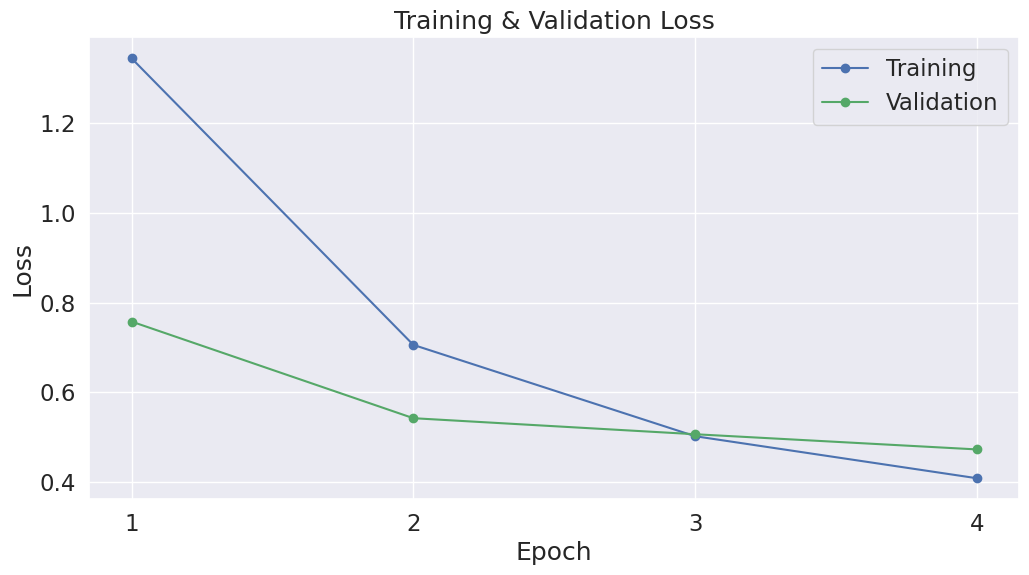

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style='darkgrid')

sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)


plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

In [22]:
model.save_pretrained('/content/drive/MyDrive/bert')
tokenizer.save_pretrained('/content/drive/MyDrive/bert')

('/content/drive/MyDrive/bert/tokenizer_config.json',
 '/content/drive/MyDrive/bert/special_tokens_map.json',
 '/content/drive/MyDrive/bert/vocab.txt',
 '/content/drive/MyDrive/bert/added_tokens.json')

In [23]:
# test_predictions(1).txt 파일에서 Generated Caption만 추출하여 sentences 변수로 저장
file_path = "/content/drive/MyDrive/epoch_8_results.txt"

# sentences 리스트 초기화
sentences = []

# 파일에서 Generated Caption 추출
with open(file_path, 'r', encoding='utf-8') as file:
    for line in file:
        if line.startswith("Generated Caption:"):
            # "Generated Caption: " 뒤의 텍스트만 추출하여 sentences 리스트에 추가
            caption = line.replace("Generated Caption: ", "").strip()
            sentences.append(caption)

# 추출한 sentences 출력 (테스트용)
print(sentences)

# 이후 sentences 변수를 기존 코드의 입력 부분에서 사용하도록 설정

input_ids = []
attention_masks = []


for sent in sentences:

    encoded_dict = tokenizer.encode_plus(
                        sent,
                        add_special_tokens = True,
                        max_length = 64,
                        pad_to_max_length = True,
                        return_attention_mask = True,
                        return_tensors = 'pt',
                        truncation=True
                   )

    input_ids.append(encoded_dict['input_ids'])
    attention_masks.append(encoded_dict['attention_mask'])

input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)

['a red car and a gray car are colliding on the road', 'two people are walking on the road with a camera next to them, and a man is walking next to them', 'a toddler wearing pink pants is climbing out of her bed', 'a man in a white shirt is walking on the road', 'a woman wearing a green skirt is sitting on the balcony railing', 'a woman in blue clothes is punching a woman in white clothes in the room', 'a man wearing pink clothes is falling from a gray car on the road', 'a gray car is upside down on the road, and a person is standing next to it', 'a white car is upside down on the road, and a tree is next to it', 'a man wearing a black jacket is sitting on the railing of a bridge', 'a white car is smashed into a tree on the road', 'a woman wearing a white shirt fell down in front of a chair in the office', 'a woman wearing a white skirt is walking on the road with a car passing by', 'a man in black clothes is punching a man in red clothes in the subway', 'a man wearing a white clothes 

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2870: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [24]:
import torch.nn.functional as F
from transformers import BertForSequenceClassification, BertTokenizer

model = BertForSequenceClassification.from_pretrained('/content/drive/MyDrive/blip_mc')
tokenizer = BertTokenizer.from_pretrained('/content/drive/MyDrive/blip_mc')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)



inputs = tokenizer(sentences, padding=True, truncation=True, return_tensors="pt")
input_ids = inputs["input_ids"].to(device)
attention_mask = inputs["attention_mask"].to(device)

model.eval()
with torch.no_grad():
    inputs = {"input_ids": input_ids, "attention_mask": attention_mask}
    outputs = model(**inputs)
    logits = outputs.logits
    probabilities = F.softmax(logits, dim=1)
    predicted_labels = torch.argmax(logits, dim=1)

label_map = {0: 'Label_0(정상)', 1: 'Label_1(위험)', 2: 'Label_2(위험)', 3: 'Label_3(위험)', 4: 'Label_4(위험)', 5: 'Label_5(위험)', 6: 'Label_6(위험)', 7: 'Label_7(위험)'}

for i, text in enumerate(sentences):
    print(f"Input: {text}")
    max_label_id = torch.argmax(probabilities[i]).item()
    max_label_name = label_map[max_label_id]
    max_label_probability = probabilities[i][max_label_id].item()

    print(f"Predicted Label: {max_label_name}")
    for label_id in range(8):
        label_name = label_map[label_id]
        label_probability = probabilities[i][label_id].item()
        print(f"{label_name} Probability: {label_probability:.4f}")
    print("="*50)

Input: a red car and a gray car are colliding on the road
Predicted Label: Label_5(위험)
Label_0(정상) Probability: 0.0067
Label_1(위험) Probability: 0.0046
Label_2(위험) Probability: 0.0076
Label_3(위험) Probability: 0.0059
Label_4(위험) Probability: 0.0057
Label_5(위험) Probability: 0.8874
Label_6(위험) Probability: 0.0559
Label_7(위험) Probability: 0.0262
Input: two people are walking on the road with a camera next to them, and a man is walking next to them
Predicted Label: Label_3(위험)
Label_0(정상) Probability: 0.0274
Label_1(위험) Probability: 0.0157
Label_2(위험) Probability: 0.0157
Label_3(위험) Probability: 0.7518
Label_4(위험) Probability: 0.1096
Label_5(위험) Probability: 0.0150
Label_6(위험) Probability: 0.0117
Label_7(위험) Probability: 0.0531
Input: a toddler wearing pink pants is climbing out of her bed
Predicted Label: Label_4(위험)
Label_0(정상) Probability: 0.0231
Label_1(위험) Probability: 0.0133
Label_2(위험) Probability: 0.0234
Label_3(위험) Probability: 0.0425
Label_4(위험) Probability: 0.8429
Label_5(위험) Prob

In [26]:
for i, text in enumerate(sentences):
    print(f"Input: {text}")
    max_label_id = torch.argmax(probabilities[i]).item()
    max_label_name = label_map[max_label_id]
    max_label_probability = probabilities[i][max_label_id].item()

    print(f"Predicted Label: {max_label_name}")

Input: a red car and a gray car are colliding on the road
Predicted Label: Label_5(위험)
Input: two people are walking on the road with a camera next to them, and a man is walking next to them
Predicted Label: Label_3(위험)
Input: a toddler wearing pink pants is climbing out of her bed
Predicted Label: Label_4(위험)
Input: a man in a white shirt is walking on the road
Predicted Label: Label_3(위험)
Input: a woman wearing a green skirt is sitting on the balcony railing
Predicted Label: Label_4(위험)
Input: a woman in blue clothes is punching a woman in white clothes in the room
Predicted Label: Label_5(위험)
Input: a man wearing pink clothes is falling from a gray car on the road
Predicted Label: Label_6(위험)
Input: a gray car is upside down on the road, and a person is standing next to it
Predicted Label: Label_5(위험)
Input: a white car is upside down on the road, and a tree is next to it
Predicted Label: Label_5(위험)
Input: a man wearing a black jacket is sitting on the railing of a bridge
Predicted